## Installation for GLIGEN

In [ ]:
!pip install diffusers transformers gradio==3.47.0 accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB

## Import libraries

In [ ]:
import gradio as gr
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import torch
from diffusers import StableDiffusionGLIGENPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Utils functions

In [ ]:
def create_bboxes(drawn_image):
    bboxes = []
    img = np.zeros(drawn_image[0].shape, dtype=np.uint8)
    for object in drawn_image:
        img += object
        nonzero_indices = np.argwhere(object > 0)
        # Calculation of min and max coords for bbox
        min_x, min_y = nonzero_indices.min(axis=0)
        max_x, max_y = nonzero_indices.max(axis=0)

        #bbox = torch.tensor([min_y, min_x, max_y, max_x], dtype=torch.int)
        bbox = [min_y, min_x, max_y, max_x]
        bboxes.append(bbox)

    img = Image.fromarray(np.dstack((img, img, img)))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf", size=18)
    colors = ["red", "olive", "blue", "green", "orange", "brown", "cyan", "purple"]
    texts = ['1', '2', '3', '4', '5', '6', '7', '8']
    for bid, box in enumerate(bboxes):
        draw.rectangle([box[0], box[1], box[2], box[3]], outline=colors[bid % len(colors)], width=4)
        anno_text = texts[bid]
        draw.rectangle([box[0], box[3] - int(font.size * 1.2), box[0] + int((len(anno_text) + 0.8) * font.size * 0.6), box[3]], outline=colors[bid % len(colors)], fill=colors[bid % len(colors)], width=4)
        draw.text([box[0] + int(font.size * 0.2), box[3] - int(font.size*1.2)], anno_text, font=font, fill='white')
    return img, bboxes

In [ ]:
def process_image(input_image):
    # Global variables that the sketchpad interacts with
    global img_with_bboxes
    global bboxes
    global drawn_image

    # Select a new shape from the overall drawing
    new_image = input_image
    if len(drawn_image) > 0:
        for img in drawn_image:
            new_image -= img
    drawn_image.append(new_image)

    # Produce bboxes
    if not img_with_bboxes:
        img_with_bboxes = Image.new(mode='RGB', size=(512, 512), color='white')
    img_with_bboxes, bboxes = create_bboxes(drawn_image)
    return img_with_bboxes

## GLIGEN Image Generation

### Load GLIGEN model

In [ ]:
gen_pipe = StableDiffusionGLIGENPipeline.from_pretrained(
    "masterful/gligen-1-4-generation-text-box", variant="fp16", torch_dtype=torch.float16
)
gen_pipe = gen_pipe.to("cuda")

unet/diffusion_pytorch_model.fp16.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### Create Bounding Boxes

In [ ]:
img_with_bboxes = None
bboxes = []
drawn_image = []

sp = gr.Sketchpad(shape=(512, 512))

# Gradio interface
iface = gr.Interface(
    fn=process_image,  # Function for processing sketchpad paintings
    inputs=sp,  # Sketchpad
    outputs=gr.outputs.Image(type='pil'), # Show user's paintings with bboxes on it
    live=True, # Update interface in real time
)

iface.launch(debug=True)

<ipython-input-16-e2016e547ba4>:11: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=gr.outputs.Image(type='pil'), # Show user's paintings with bboxes on it


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://be8779da49bb42b271.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://be8779da49bb42b271.gradio.live


## Generate Images

In [ ]:
bboxes = [[value/512 for value in bbox] for bbox in bboxes] # Normalize values to [0, 1] interval

In [ ]:
bboxes

[[0.0, 0.052734375, 0.953125, 0.544921875],
 [0.28125, 0.537109375, 0.62890625, 0.857421875],
 [0.0, 0.623046875, 0.2265625, 0.978515625],
 [0.701171875, 0.591796875, 0.9765625, 0.970703125]]

In [ ]:
prompt = "a mouse playing soccer with a cat in a forest"
phrases = ["a mouse", "a soccer ball", 'a cat', 'a forest']

In [ ]:
images = gen_pipe(
    prompt=prompt, # Text description of the picture
    num_images_per_prompt = 4,
    gligen_phrases=phrases, # Objects to be generated
    gligen_boxes=bboxes, # Bboxes of these objects
    gligen_scheduled_sampling_beta=1,
    output_type="numpy",
    num_inference_steps=50,
).images

images = (images * 255).astype(np.uint8)
images = np.concatenate(images, axis=1)

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_gligen.py:711: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_gligen.py:744: FutureWarning: Accessing config attribute `cross_attention_dim` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'cross_attention_dim' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.cross_attention_dim'.
  max_objs, self.unet.cross_attention_dim, device=device, dtype=self.text_encoder.dtype


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:340: FutureWarning: the output_type numpy is outdated and has been set to `np`. Please make sure to set it to one of these instead: `pil`, `np`, `pt`, `latent`
  deprecate("Unsupported output_type", "1.0.0", deprecation_message, standard_warn=False)


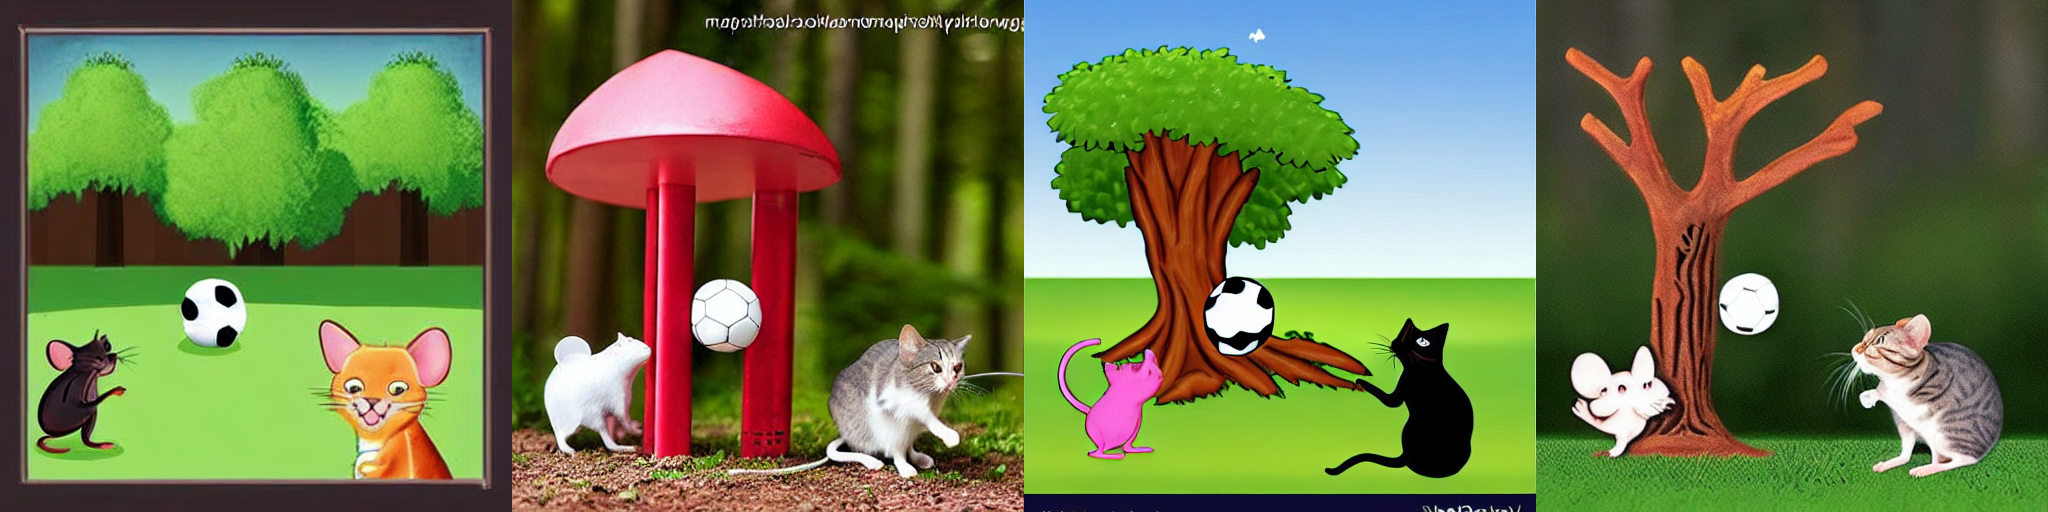

In [ ]:
Image.fromarray(images)